# Evaluate Retrieval Homogenity

In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

DIR = '/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/retrievalExperiments/runs-ecir22/features-retrieval-homogenity/'

df = pd.read_json(DIR +'retrieval-homogenity-runs-evaluated.jsonl', lines=True)
df = df[['index', 'topic', 'jensen_shannon_distance', 'retrieval_model']].groupby(['index', 'topic'])\
    .agg(jensen_shannon_distance=('jensen_shannon_distance', 'mean'), count=('retrieval_model', 'count')).reset_index()

df

,index,topic,jensen_shannon_distance,count
0,cc-19-47-anchortext,2004033,0.266951,252
1,cc-19-47-anchortext,2004062,0.255685,252
2,cc-19-47-anchortext,2006789,0.276301,252
3,cc-19-47-anchortext,2006876,0.234652,252
4,cc-19-47-anchortext,2007147,0.286636,252
...,...,...,...,...
27499,ms-marco-content,12847048,0.189107,252
27500,ms-marco-content,12853262,0.252833,252
27501,ms-marco-content,12853353,0.288452,252
27502,ms-marco-content,12853486,0.354842,252


In [2]:
def load_trec_run(file_name):
    from trectools import TrecRun
    return TrecRun(DIR + '../runs-retrieval-homogenity/' + file_name).run_data
def topics_with_too_few_results(file_name):
    run = load_trec_run(file_name)
    topics = run['query'].unique()
    topics_with_enough_results = set(run[(run['rank'] == 1000)]['query'].unique())
    return [i for i in topics if i not in topics_with_enough_results]

topics_to_remove = set(
    topics_with_too_few_results('run.cc-19-47-anchortext.bm25-default.txt') \
    + topics_with_too_few_results('run.ms-marco-content.bm25-default.txt')
)

In [3]:
len(topics_to_remove)

1656

In [4]:
df['topic_must_be_removed'] = df['topic'].apply(lambda i: i in topics_to_remove)
df

,index,topic,jensen_shannon_distance,count,topic_must_be_removed
0,cc-19-47-anchortext,2004033,0.266951,252,False
1,cc-19-47-anchortext,2004062,0.255685,252,False
2,cc-19-47-anchortext,2006789,0.276301,252,False
3,cc-19-47-anchortext,2006876,0.234652,252,False
4,cc-19-47-anchortext,2007147,0.286636,252,False
...,...,...,...,...,...
27499,ms-marco-content,12847048,0.189107,252,False
27500,ms-marco-content,12853262,0.252833,252,True
27501,ms-marco-content,12853353,0.288452,252,True
27502,ms-marco-content,12853486,0.354842,252,False


# Plot: figure-retrieval-homogenity

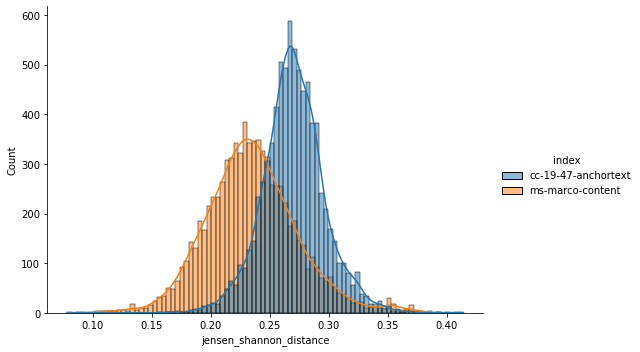

In [18]:
fig = sns.displot(data=df[(df['index'] != 'cc-19-47-anchortext-on-anchortext-index') & (df['topic_must_be_removed'] == False)], x='jensen_shannon_distance', hue='index', kde=True, aspect=1.4
                 )
fig.savefig('figure-retrieval-homogenity.pdf')

In [7]:
df_plot

,topic,js-anchortext,js-content,diff-content-minus-anchor,query
0,2004033,0.266951,0.250177,-0.016774,good woods for carving
1,2004062,0.255685,0.213498,-0.042187,chance the rapper networth
2,2006789,0.276301,0.189763,-0.086538,mlb advanced media
3,2006876,0.234652,0.263943,0.029291,eclectic energies test
4,2007147,0.286636,0.200496,-0.086140,best netflix shows of all time
...,...,...,...,...,...
7957,12844252,0.252550,0.305439,0.052889,dept of veterans
7958,12844550,0.271011,0.228018,-0.042993,michigan sos online services
7959,12847048,0.290101,0.189107,-0.100994,severe tricuspid regurgitation
7960,12853486,0.324642,0.354842,0.030200,https://www.amortization-calc.com/


# Table Pairwise comparison

In [54]:
def significant_difference(a, b, pvalue):
    from scipy.stats import ttest_ind
    ret = ttest_ind(a, b)
    if ret.pvalue >= pvalue:
        return 'Equal'
    elif ret.statistic > 0:
        return 'Left'
    elif ret.statistic < 0:
        return 'Right'
    else:
        raise ValueError('TBD')
        
print(significant_difference([1,2,3,4], [0,1,0.5,0], 0.05))
print(significant_difference([1,2,3,4], [0,1,0.5,0], 0.01))
print(significant_difference([0,1,0.5,0], [1,2,3,4], 0.05))


df_pairs_tmp = pd.read_json(DIR +'retrieval-homogenity-runs-evaluated.jsonl', lines=True)
df_pairs = []

for topic in tqdm(df_pairs_tmp['topic'].unique()):
    df_topic = df_pairs_tmp[df_pairs_tmp['topic'].astype(int) == int(topic)]
    anchor = df_topic[df_topic['index'] == 'cc-19-47-anchortext']['jensen_shannon_distance']
    content = df_topic[df_topic['index'] == 'ms-marco-content']['jensen_shannon_distance']
    
    if len(anchor) != 252 or len(content) != 252:
        continue
    
    df_pairs += [{
        'topic': topic,
        'content_vs_anchor_p_0_10': significant_difference(content, anchor, 0.10),
        'content_vs_anchor_p_0_05': significant_difference(content, anchor, 0.05),
        'content_vs_anchor_p_0_01': significant_difference(content, anchor, 0.01),
    }]

df_pairs = pd.DataFrame(df_pairs)
df_pairs['topic_must_be_removed'] = df_pairs['topic'].apply(lambda i: i in topics_to_remove)
df_pairs

Left
Equal
Right


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 9333/9333 [03:38<00:00, 42.63it/s]


,topic,content_vs_anchor_p_0_10,content_vs_anchor_p_0_05,content_vs_anchor_p_0_01,topic_must_be_removed
0,8913837,Right,Right,Right,False
1,8914478,Right,Right,Right,False
2,8915349,Left,Left,Left,False
3,8915623,Right,Right,Right,False
4,8916901,Left,Left,Left,False
...,...,...,...,...,...
9081,10939880,Right,Right,Right,False
9082,10940428,Right,Right,Right,True
9083,10943598,Right,Right,Right,False
9084,10947099,Right,Right,Right,False


In [69]:
def f(i):
    return str(i)

def plot_table_tmp(df):
    lines = []
    for p_value in [('content_vs_anchor_p_0_10', '0.10'), ('content_vs_anchor_p_0_05', '0.05'), ('content_vs_anchor_p_0_01', '0.01')]:
        stats = df[['topic', p_value[0]]].groupby(p_value[0]).count().to_dict()['topic']
        
        lines += [p_value[1] + ' & ' + f(stats['Equal']) + ' / ' + f(stats['Right']) + ' / ' + f(stats['Left']) + ' \\\\'];
    
    return '''\\begin{tabular}{@{}lr@{}}
\\toprule
p & $ \\Leftrightarrow/~\\uparrow/~\\downarrow$ \\\\
\\midrule
''' + ('\n'.join(lines)) + '''
\\bottomrule
\\end{tabular}'''

print(plot_table_tmp(df_pairs[df_pairs['topic_must_be_removed'] == False]))

\begin{tabular}{@{}lr@{}}
\toprule
p & $ \Leftrightarrow/~\uparrow/~\downarrow$ \\
\midrule
0.10 & 71 / 6770 / 1121 \\
0.05 & 85 / 6764 / 1113 \\
0.01 & 116 / 6748 / 1098 \\
\bottomrule
\end{tabular}


In [6]:
df[df['topic_must_be_removed'] == False].groupby('index').mean()

,topic,jensen_shannon_distance,count,topic_must_be_removed
index,,,,
cc-19-47-anchortext,7.478000e+06,0.270188,252.0,0.0
cc-19-47-anchortext-on-anchortext-index,7.478000e+06,0.528045,252.0,0.0
ms-marco-content,7.478000e+06,0.234854,252.0,0.0


In [5]:
df_plot = []

def topics():
    ret = {}
    with open('../../Data/topics.retrieval-homogenity.tsv') as f:
        for i in f:
            i = i.split('\t')
            assert len(i) == 2
            ret[int(i[0])] = i[1].strip()
    return ret

all_topics = topics()



for topic in tqdm(df['topic'].unique()):
    if topic in topics_to_remove:
        continue
    
    tmp_del = {}
    for _, i in df[df['topic'] == topic].iterrows():
        tmp_del[i['index']] = i['jensen_shannon_distance']
    if 'cc-19-47-anchortext' in tmp_del and 'ms-marco-content' in tmp_del:
        df_plot += [{
            'topic': topic,
            'js-anchortext': tmp_del['cc-19-47-anchortext'],
            'js-content': tmp_del['ms-marco-content'],
        }]
df_plot = pd.DataFrame(df_plot)
df_plot['diff-content-minus-anchor'] = df_plot['js-content'] - df_plot['js-anchortext']
df_plot['query'] = df_plot['topic'].apply(lambda i: all_topics[int(i)])
df_plot

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 9333/9333 [00:02<00:00, 3485.50it/s]


,topic,js-anchortext,js-content,diff-content-minus-anchor,query
0,2004033,0.266951,0.250177,-0.016774,good woods for carving
1,2004062,0.255685,0.213498,-0.042187,chance the rapper networth
2,2006789,0.276301,0.189763,-0.086538,mlb advanced media
3,2006876,0.234652,0.263943,0.029291,eclectic energies test
4,2007147,0.286636,0.200496,-0.086140,best netflix shows of all time
...,...,...,...,...,...
7957,12844252,0.252550,0.305439,0.052889,dept of veterans
7958,12844550,0.271011,0.228018,-0.042993,michigan sos online services
7959,12847048,0.290101,0.189107,-0.100994,severe tricuspid regurgitation
7960,12853486,0.324642,0.354842,0.030200,https://www.amortization-calc.com/


In [6]:
df_plot.sort_values('diff-content-minus-anchor')

,topic,js-anchortext,js-content,diff-content-minus-anchor,query
4012,7570173,0.320772,0.131847,-0.188925,kelly clarkson fan club
7121,11714973,0.301234,0.114230,-0.187004,young maria cheat codes
2417,5397705,0.291762,0.110331,-0.181431,old baywatch cast
879,3202658,0.273304,0.092482,-0.180822,rock splitting
5426,9470346,0.278657,0.103379,-0.175278,brazilian restaurants nyc
...,...,...,...,...,...
104,2122591,0.214430,0.312991,0.098561,"williamstown, nj"
7709,12481508,0.166972,0.268524,0.101552,get human irs
4878,8702061,0.262183,0.365111,0.102927,ann harris bennett tax assessor-collector
6486,10842365,0.266099,0.370809,0.104710,conjugation of etre french


In [7]:
run_anchor = load_trec_run('run.cc-19-47-anchortext.bm25-default.txt')
run_content = load_trec_run('run.ms-marco-content.bm25-default.txt')

# Investigate Query 7570173 "kelly clarkson fan club"

In [13]:
import ir_datasets

#ms_marco_docs = ir_datasets.load('msmarco-document').docs_store()

In [14]:
run_anchor[(run_anchor['query'] == 7570173) & (run_anchor['rank'] <= 100)]

,query,q0,docid,rank,score,system
4243841,7570173,Q0,D2271179,1,20.8834,Anserini
4243842,7570173,Q0,D825842,2,17.9478,Anserini
4243843,7570173,Q0,D2560890,3,16.7078,Anserini
4243844,7570173,Q0,D1940616,4,15.1007,Anserini
4243845,7570173,Q0,D825843,5,14.1673,Anserini
...,...,...,...,...,...,...
4243936,7570173,Q0,D2874600,96,7.4762,Anserini
4243937,7570173,Q0,D1964585,97,7.4704,Anserini
4243938,7570173,Q0,D566017,98,7.4466,Anserini
4243939,7570173,Q0,D2565092,99,7.4422,Anserini


In [ ]:
import ir_datasets
ms_marco_docs = ir_datasets.load('msmarco-document').docs_store()

In [ ]:
for i in [('anchor-1', 'D2271179'), ('anchor-2', 'D825842'), ('anchor-3', 'D2560890'), ('anchor-98', 'D566017'), ('anchor-99', 'D2565092'), ('100', 'D1548127')]:
    print(('#'*25) + '\n# ' + i[0] + '\n' + ('#'*25) + '\n' + str(ms_marco_docs.get(i[1]))[:750] + '\n\n')


In [16]:
run_content[(run_content['query'] == 7570173) & (run_content['rank'] <= 100)]

,query,q0,docid,rank,score,system
4561266,7570173,Q0,D2271181,1,13.1976,Anserini
4561267,7570173,Q0,D502231,2,13.1947,Anserini
4561268,7570173,Q0,D825843,3,12.9622,Anserini
4561269,7570173,Q0,D497872,4,12.6839,Anserini
4561270,7570173,Q0,D1940614,5,12.3620,Anserini
...,...,...,...,...,...,...
4561361,7570173,Q0,D1940616,96,9.5336,Anserini
4561362,7570173,Q0,D2145785,97,9.5332,Anserini
4561363,7570173,Q0,D2337737,98,9.5303,Anserini
4561364,7570173,Q0,D497873,99,9.5174,Anserini


In [ ]:
for i in [('content-1', 'D2271181'), ('content-2', 'D502231'), ('content-3', 'D825843'), ('content-98', 'D2337737'), ('content-99', 'D497873'), ('content-100', 'D1940617')]:
    print(('#'*25) + '\n# ' + i[0] + '\n' + ('#'*25) + '\n' + str(ms_marco_docs.get(i[1]))[:750] + '\n\n')

# Old Stuff

In [70]:
def topics(file_name):
    import json
    ret = {}
    with open(DIR + file_name) as f:
        for i in f:
            i = json.loads(i)
            docFreq = [t['docFreq'] for t in i['terms']]
            
            if len(docFreq) == 0:
                ret[int(i['queryId'])] = {
                    'minDocFreq': 0,
                    'maxDocFreq': 0,
                    'sumDocFreq': 0,
                    'meanDocFreq': 0,
                    'length_in_terms': 0,
                }                
            else:
                ret[int(i['queryId'])] = {
                    'minDocFreq': min(docFreq),
                    'maxDocFreq': max(docFreq),
                    'sumDocFreq': sum(docFreq),
                    'meanDocFreq': sum(docFreq)/len(docFreq),
                    'length_in_terms': len(docFreq)
                }
    return ret

query_stats = {
    'cc-19-47-anchortext-on-anchortext-index': topics('document-frequency-of-queries-on-cc-19-47-anchortext.jsonl'),
    'cc-19-47-anchortext': topics('document-frequency-of-queries-on-cc-19-47-anchortext.jsonl'),
    'ms-marco-content': topics('document-frequency-of-queries-on-ms-marco-content.jsonl'),
}

In [73]:
df['minDocFreq'] = df.apply(lambda i: query_stats[i['index']][i['topic']]['minDocFreq'],axis=1)
df['maxDocFreq'] = df.apply(lambda i: query_stats[i['index']][i['topic']]['maxDocFreq'],axis=1)
df['sumDocFreq'] = df.apply(lambda i: query_stats[i['index']][i['topic']]['sumDocFreq'],axis=1)
df['meanDocFreq'] = df.apply(lambda i: query_stats[i['index']][i['topic']]['meanDocFreq'],axis=1)

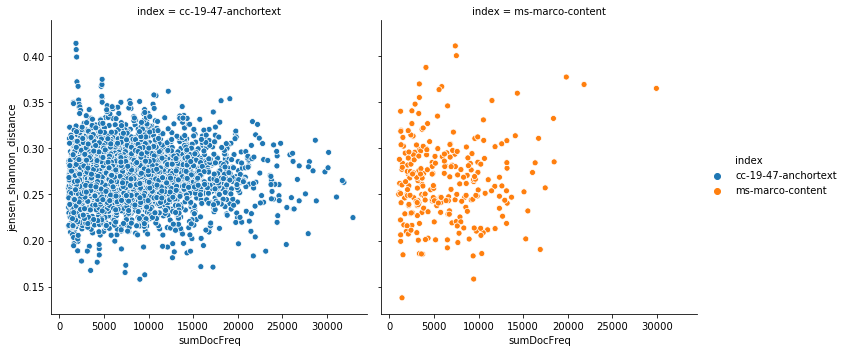

In [101]:
p = sns.relplot(data=df[(df['maxDocFreq'] > 1000) & (df['maxDocFreq'] < 10000) & (df['index'] != 'cc-19-47-anchortext-on-anchortext-index')], x='sumDocFreq', y='jensen_shannon_distance', hue='index', col='index')
#p.set(xscale="log")

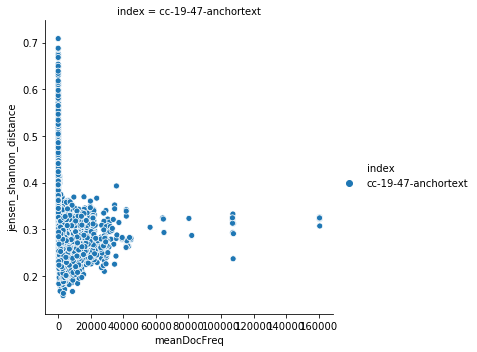

In [82]:
p = sns.relplot(data=df[df['index'] == 'cc-19-47-anchortext'], x='meanDocFreq', y='jensen_shannon_distance', hue='index', col='index')

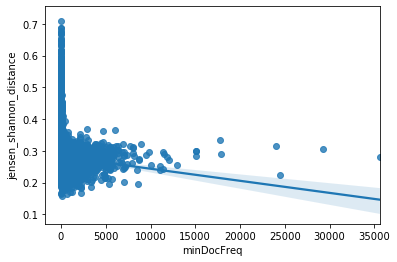

In [86]:
sns.regplot(x='minDocFreq', y='jensen_shannon_distance', data=df[df['index'] == 'cc-19-47-anchortext']);

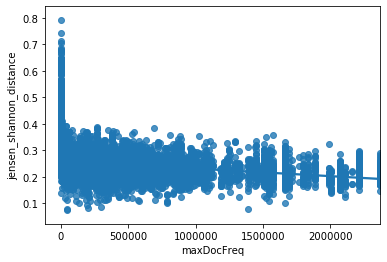

In [88]:
sns.regplot(x='maxDocFreq', y='jensen_shannon_distance', data=df[df['index'] == 'ms-marco-content']);

In [65]:

!head -3 {DIR}/document-frequency-of-queries-on-cc-19-47-anchortext.jsonl

{"queryId":2004033,"query":"good woods for carving","terms":[{"term":"good","docFreq":10003},{"term":"wood","docFreq":1505},{"term":"carv","docFreq":154}]}
{"queryId":2004062,"query":"chance the rapper networth","terms":[{"term":"chanc","docFreq":883},{"term":"rapper","docFreq":160},{"term":"networth","docFreq":27}]}
{"queryId":2006789,"query":"mlb advanced media","terms":[{"term":"mlb","docFreq":370},{"term":"advanc","docFreq":2188},{"term":"media","docFreq":3463}]}


In [66]:
!head -3 {DIR}/document-frequency-of-queries-on-ms-marco-content.jsonl

{"queryId":2004033,"query":"good woods for carving","terms":[{"term":"good","docFreq":915454},{"term":"wood","docFreq":159732},{"term":"carv","docFreq":29105}]}
{"queryId":2004062,"query":"chance the rapper networth","terms":[{"term":"chanc","docFreq":245591},{"term":"rapper","docFreq":18818},{"term":"networth","docFreq":774}]}
{"queryId":2006789,"query":"mlb advanced media","terms":[{"term":"mlb","docFreq":10520},{"term":"advanc","docFreq":304499},{"term":"media","docFreq":268386}]}


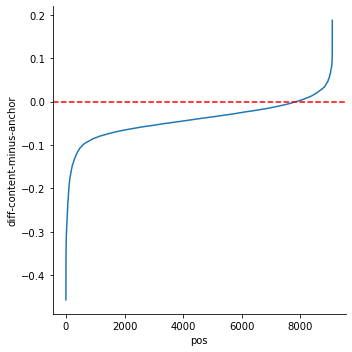

In [62]:
df_tmp = df_plot.sort_values('diff-content-minus-anchor').reset_index().reset_index()
del df_tmp['index']
df_tmp = df_tmp.rename(columns={'level_0': 'pos'})

g = sns.relplot(data=df_tmp, x='pos', y='diff-content-minus-anchor', kind='line')
g.axes[0][0].axhline(0, ls='--', color='r')

g

In [63]:
df_tmp

,pos,topic,js-anchortext,js-content,diff-content-minus-anchor,query
0,0,11813584,0.614541,0.158239,-0.456302,amal graafstra
1,1,7503258,0.649414,0.262047,-0.387367,hgst rma
2,2,2466124,0.667040,0.287856,-0.379184,flannel
3,3,9477195,0.610122,0.244168,-0.365954,www.espn sports.com
4,4,7839322,0.608578,0.250964,-0.357614,harriman
...,...,...,...,...,...,...
9081,9081,12481508,0.166972,0.268524,0.101552,get human irs
9082,9082,8702061,0.262183,0.365111,0.102927,ann harris bennett tax assessor-collector
9083,9083,10842365,0.266099,0.370809,0.104710,conjugation of etre french
9084,9084,11557759,0.162837,0.270287,0.107451,mn irs forms


# Calculate Retrieval Homogenity

In [1]:
!/home/jovyan/.local/bin/nosetests -w ../jupyter/

import sys
import pandas as pd
sys.path.append('../jupyter/')
import json
from util import evaluate_retrieval_homogenity, run_homogenity_experiments

DIR = '/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/retrievalExperiments/runs-ecir22/features-retrieval-homogenity/'

.......................
----------------------------------------------------------------------
Ran 23 tests in 3.736s

OK


In [ ]:
# Process runs with hadoop

In [2]:
import pyspark

sc = pyspark.SparkContext()
sc.addPyFile('../jupyter/util.py')
sc

<SparkContext master=yarn appName=pyspark-shell>

In [3]:
def homogenity_experiment_on_topic(entry):
    import json
    
    for i in run_homogenity_experiments(entry['topic_data']):
        i['index'] = entry['index']
        i['retrieval_model'] = entry['retrieval_model']
        yield json.dumps(i)

def homogenity_entries(index, retrieval_model):
    file_name = 'file://' + DIR + '/run.' + index + '.' + retrieval_model + '.txt.jsonl'
    
    return sc.textFile(file_name).repartition(10000)\
        .map(lambda i: {'topic_data': i, 'index': index, 'retrieval_model': retrieval_model})

In [ ]:
data = homogenity_entries(index='cc-19-47-anchortext', retrieval_model='bm25-default')
data = data.union(homogenity_entries(index='ms-marco-content', retrieval_model='bm25-default'))
data = data.union(homogenity_entries(index='cc-19-47-anchortext-on-anchortext-index', retrieval_model='bm25-default'))

data.flatMap(homogenity_experiment_on_topic)\
        .saveAsTextFile('ecir22/anchor-text/retrieval-homogenity.jsonl')

In [1]:
# Process run files locally

Attention: this does the same as the code above with hadoop does, but running it locally takes too long. Hence do not run the code below (only on few examples like 100 queries)

done


In [ ]:
### cc-19-47-anchortext

In [ ]:
index='cc-19-47-anchortext'
retrieval_model='bm25-default'
df = evaluate_retrieval_homogenity(DIR, index, retrieval_model, 20)
df = pd.DataFrame(df)
df.to_json('homogenity.' + index +'.' + retrieval_model +'.jsonl', lines=True, orient='records')

In [ ]:
### cc-19-47-anchortext-conjunction

In [2]:
index='cc-19-47-anchortext'
retrieval_model='bm25-conjunction-default'
df = evaluate_retrieval_homogenity(DIR, index, retrieval_model, 20)
df = pd.DataFrame(df)
df.to_json('homogenity.' + index +'.' + retrieval_model +'.jsonl', lines=True, orient='records')

In [ ]:
### Content-conjunction

In [ ]:
index='ms-marco-content'
retrieval_model='bm25-conjunction-default'
df = evaluate_retrieval_homogenity(DIR, index, retrieval_model, 20)
df = pd.DataFrame(df)
df.to_json('homogenity.' + index +'.' + retrieval_model +'.jsonl', lines=True, orient='records')

In [ ]:
### Content

In [ ]:
index='ms-marco-content'
retrieval_model='bm25-default'
df = evaluate_retrieval_homogenity(DIR, index, retrieval_model, 20)
df = pd.DataFrame(df)
df.to_json('homogenity.' + index +'.' + retrieval_model +'.jsonl', lines=True, orient='records')

In [ ]:
### ORCAS

In [ ]:
index='orcas'
retrieval_model='bm25-default'
df = evaluate_retrieval_homogenity(DIR, index, retrieval_model, 20)
df = pd.DataFrame(df)
df.to_json('homogenity.' + index +'.' + retrieval_model +'.jsonl', lines=True, orient='records')

In [1]:
!ls /mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/retrievalExperiments/runs-ecir22/features-retrieval-homogenity/

run.cc-16-07-anchortext.bm25-default.txt.jsonl
run.cc-16-07-anchortext.bm25+rm3-default.txt.jsonl
run.cc-16-07-anchortext.qld-default.txt.jsonl
run.cc-17-04-anchortext.bm25-default.txt.jsonl
run.cc-17-04-anchortext.bm25+rm3-default.txt.jsonl
run.cc-17-04-anchortext.qld-default.txt.jsonl
run.cc-18-13-anchortext.bm25-default.txt.jsonl
run.cc-18-13-anchortext.bm25+rm3-default.txt.jsonl
run.cc-18-13-anchortext.qld-default.txt.jsonl
run.cc-19-47-anchortext.bm25-default.txt.jsonl
run.cc-19-47-anchortext.bm25+rm3-default.txt.jsonl
run.cc-19-47-anchortext.qld-default.txt.jsonl
run.cc-20-05-anchortext.bm25-default.txt.jsonl
run.cc-20-05-anchortext.bm25+rm3-default.txt.jsonl
run.cc-20-05-anchortext.qld-default.txt.jsonl
run.cc-21-04-anchortext.bm25-default.txt.jsonl
run.cc-21-04-anchortext.bm25+rm3-default.txt.jsonl
run.cc-21-04-anchortext.qld-default.txt.jsonl
run.ms-marco-content.bm25-default.txt.jsonl
run.ms-marco-content.bm25+rm3-default.txt.jsonl
run.ms-marco-content.qld-default.txt.jsonl
r